<a href="https://colab.research.google.com/github/metamatematico/Experimentos-IA/blob/master/Reto_08_WGAN_GP_Rostros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias a utilizar

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Dropout, BatchNormalization, UpSampling2D, LeakyReLU
from keras.models import Model
from keras import backend as K
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint 

from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import glob

# Generar el modelo de WGAN-GP

In [ ]:
#Discriminador / en este caso tambien llamada funcion critica
def build_discriminador():
  xx = Input(input_size)
  conv1 = Conv2D(64,5,strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(___)
  conv2 = Conv2D(64,5,strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(___)
  conv3 = Conv2D(128,5,strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(___)
  conv4 = Conv2D(128,5,strides=(1,1),padding='same',activation=LeakyReLU(alpha=0.2))(___)
  f = Flatten()(conv4)
  d1 = Dense(1, activation=None)(f) # La activacion para una GAN es sigmoid
  model = Model(xx,d1)

  return model


#Generador
def build_generador ():

  g_x = Input(shape=(latent_dim))
  d = Dense(4096)(g_x)
  d = BatchNormalization()(d)
  r = Reshape((8,8,64))(d)

  dec1 = UpSampling2D(size=(2,2))(r)
  dec1 = Conv2D(128,5,strides=(1,1), padding='same', activation=LeakyReLU(alpha=0.2))(dec1)
  dec1 = BatchNormalization(momentum=0.8)(dec1)

  dec2 = UpSampling2D(size=(2,2))(dec1)
  dec2 = Conv2D(64,5,strides=(1,1), padding='same', activation=LeakyReLU(alpha=0.2))(dec2)
  dec2 = BatchNormalization(momentum=0.8)(dec2)

  dec3 = Conv2D(64,5,strides=(1,1), padding='same', activation=LeakyReLU(alpha=0.2))(dec2)
  dec3 = BatchNormalization(momentum=0.8)(dec3)

  dec4 = Conv2D(3,5,strides=(1,1), padding='same', activation='tanh')(dec3)

  model = Model(g_x, dec4)

  return model

In [ ]:
# Wasserstein Loss Function
def wasserstein_loss(y_true, y_pred):
	return K.mean(y_true * y_pred)

In [ ]:
# Constriur los modelos
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def build_WGANgp (generador, discriminador):

  # Generador de la imagen falsa
  z = Input(shape=(latent_dim,))
  f_img = generador(z)
  f_out = discriminador(f_img)

  # Imagen real
  r_img = Input(shape= input_size)
  r_out = discriminador(r_img)

  # imagen promediada entre la real y la falsa
  epsilon = K.placeholder(shape=(None,1,1,1))
  a_img = Input(shape=(input_size), tensor= epsilon * r_img + (1-epsilon) * f_img)
  a_out = discriminador(a_img)

  # Funciones de perdida
  r_loss = K.mean(r_out)
  f_loss = K.mean(f_out)

  # Penalizacion del gradiente   [Parte importante del WGAN-GP]
  grad_mixed = K.gradients(a_out, [a_img])[0]
  norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
  grad_penalty = K.mean(K.square(norm_grad_mixed-1))
  penalty = penaltyLambda * grad_penalty

  d_loss = f_loss - r_loss + penalty

  # Actualizar el discriminador
  d_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
              get_updates(params=discriminador.trainable_weights,loss=d_loss)
  d_train = K.function([r_img, z, epsilon],
                        [r_loss, f_loss, penalty, d_loss],
                        d_updates)

  # Actualizar el generador
  g_loss = -1. * f_loss
  g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9). \
              get_updates(params=generador.trainable_weights,loss=g_loss)
  g_train = K.function([z], [g_loss], g_updates)

  return g_train, d_train



In [ ]:
# Se necesita entrenar el modelo en dos secciones, una para el discriminador y otra para el generador
# Con ayuda del discriminador se entrena el generador

def train(epochs, batch_size=32, sample_interval=50):#
  X_train = np.array(datos)
  X_train = X_train / 127.5 - 1
  X_train = np.clip(X_train, -1, 1)

  for epoch in range(epochs):

    #------------------------------------------------------------------------------------------
    # ENTRENAR EL DISCRIMINADOR (CRITIC)

    for _ in range(n_critic):

      epsilon = np.random.uniform(size = (batch_size, 1,1,1))
      z = np.random.normal(0, 1, (batch_size, latent_dim))
      f_imgs = generador.predict(z)

      idx = np.random.randint(0, X_train.shape[0], batch_size) # Escoje numero aleatoriamente
      r_imgs = X_train[idx]                                      # Toma idx imagenes reales

      r_loss, f_loss, penalty, d_loss = D_train([r_imgs,z, epsilon])


    # ENTRENAMIENTO DEL GENERADOR
    z = np.random.normal(0, 1, (batch_size, latent_dim)) # crea ruidos aleatorios
    g_loss = G_train([z])         # Observa la perdida del generador

    print ('Epoca: ',epoch, '  D_loss: ', d_loss, '  G_loss: ', g_loss)
    if epoch % sample_interval == 0:
      sample_images(epoch)

def sample_images(epoch):
  # Completar la funcion
  plt.show()

# Observar los objetos originales

In [ ]:
# Uso en COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar la base de datos previamente reducida

# CelebA 32x32
datos = np.load('/content/drive/MyDrive/01 Deep Learning Generativo para IA creativa/Parte 1/Dataset/celeba5000.npy')

TypeError: ignored

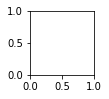

In [ ]:
# Visualizar los datos
fig = plt.figure(figsize=(8,4))
for i in range (0,9):
  a = fig.add_subplot(3,5,i+1)
  plt.imshow(datos)
plt.show()



In [ ]:
# Parametros del modelo
input_size = (32,32,3)
latent_dim = 100
d_p = 0.2

penaltyLambda = 10

generador = build_generador()
discriminador = build_discriminador()
G_train, D_train = build_WGANgp(generador, discriminador)

In [ ]:
#generador.___()
#discriminador.___()

In [ ]:
# Entrenar el modelo
n_critic = 5 # Numero de entrenamiento de la funcion critica por veces del generador
train(epochs=5000, batch_size=32, sample_interval=100)

In [ ]:
# probar el modelo terminado

sample_images(epoch=___)
